Starting K-NN Experiment...
Data loaded successfully. Shape: (784, 1877)
Running experiment for n=10...
Running experiment for n=20...
Running experiment for n=40...
Running experiment for n=80...
Experiment complete. Generating plots...


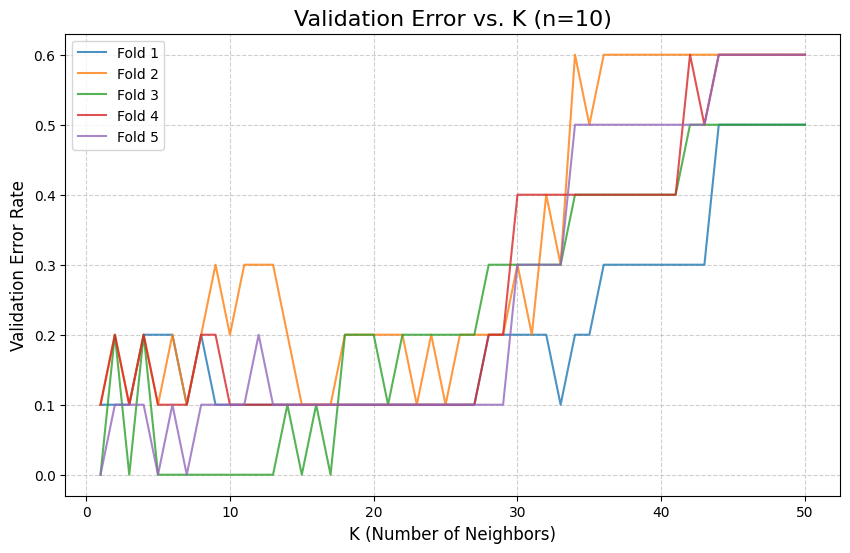

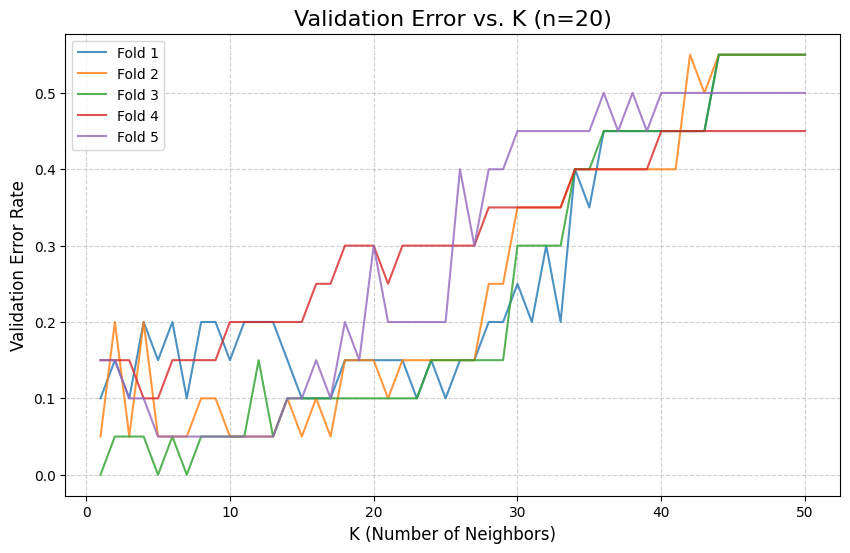

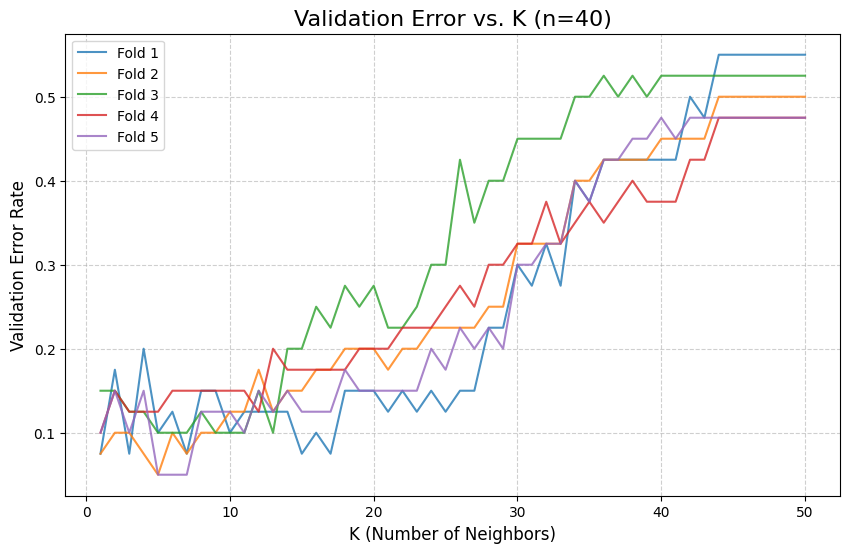

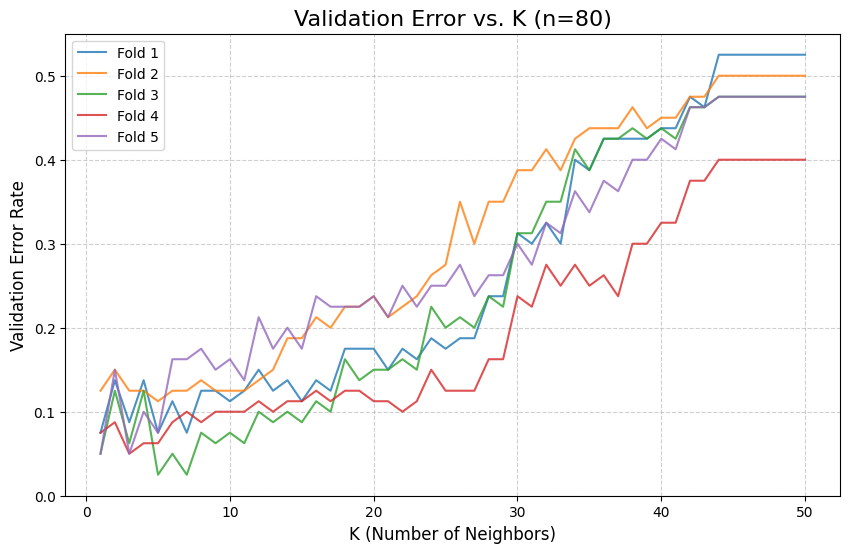

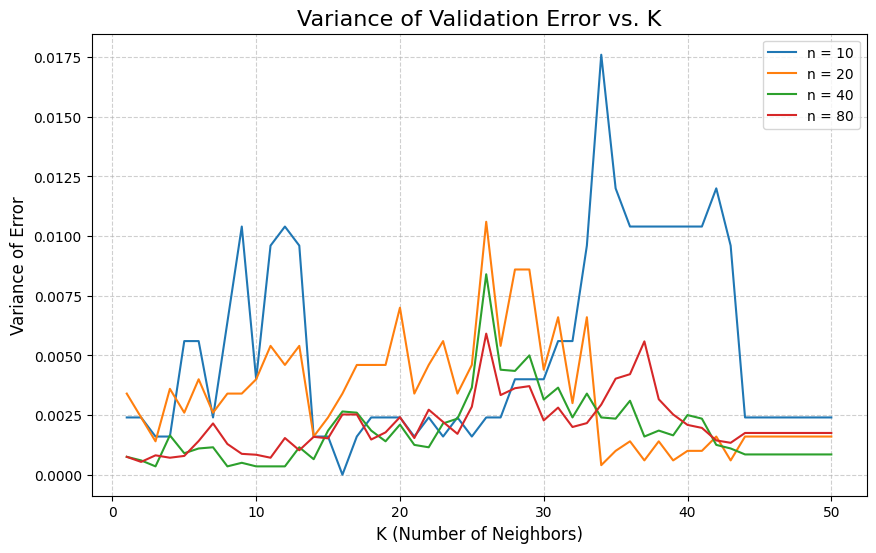

All plots generated and saved.


In [1]:
# --- For Task 1 ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Constants ---
DATA_DIR = Path("./") # It is for the the "current folder"

DATA_FILE = DATA_DIR / "MNIST-5-6-Subset.txt"
LABELS_FILE = DATA_DIR / "MNIST-5-6-Subset-Labels.txt"

# --- Add paths for the corrupted data (for Task #2 later) ---
LIGHT_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Light-Corruption.txt"
MODERATE_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Moderate-Corruption.txt"
HEAVY_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Heavy-Corruption.txt"


M_TRAIN = 50  # Number of training points
K_VALUES = np.arange(1, M_TRAIN + 1) # It creates an array of numbers, [1,2,...,50]
N_VALUES = [10, 20, 40, 80]  # Validation set sizes

# -----------------------------------------------------------------
# PART 1: The Vectorized K-NN Function
# -----------------------------------------------------------------

def knn(training_points, training_labels, test_points, test_labels):
    """
    Implements a fully vectorized K-NN classifier.

    Args:
        training_points (np.array): (d, m) matrix of training data
        training_labels (np.array): (m,) vector of training labels {5, 6}
        test_points (np.array): (d, n) matrix of test data
        test_labels (np.array): (n,) vector of test labels {5, 6}

    Returns:
        np.array: (m,) vector of average error for K=1 to K=m
    """

    # Get dimensions
    d, m = training_points.shape
    d, n = test_points.shape

    # 1. Convert labels from {5, 6} to {-1, 1}
    # This makes the "voting" part possible with simple addition
    train_labels_norm = np.where(training_labels == 5, -1, 1)
    test_labels_norm = np.where(test_labels == 5, -1, 1)

    # 2. Compute the (m x n) distance matrix without loops
    # This is the "diag trick" from the assignment
    # D^2 = (x^T * x) - 2(x^T * z) + (z^T * z)

    # (m, 1) vector of x^T * x
    # np.sum(np.square(...), axis=0) computes the squared norm for each column
    term1 = np.sum(np.square(training_points), axis=0).reshape(m, 1)

    # (m, n) matrix of -2 * x^T * z
    term2 = -2 * (training_points.T @ test_points)

    # (1, n) vector of z^T * z
    term3 = np.sum(np.square(test_points), axis=0).reshape(1, n)

    # Broadcasting (m,1) + (m,n) + (1,n) gives the (m,n) distance matrix
    # We add a small epsilon for numerical stability, just in case of dist=0
    dist_matrix_D = term1 + term2 + term3 + 1e-10

    # 3. Get predictions for all K at once (the "cumsum trick")

    # (m, n) matrix of indices that sort D down the columns
    sorted_indices = np.argsort(dist_matrix_D, axis=0)

    # Re-order the training labels according to the sorted distances
    # sorted_labels[k, j] is the label of the k-th nearest neighbor to test point j
    sorted_labels = train_labels_norm[sorted_indices]

    # (m, n) matrix of cumulative votes.
    # row K = sum of votes from K=1 to K
    cumulative_votes = np.cumsum(sorted_labels, axis=0)

    # (m, n) matrix of predictions.
    # np.sign() turns positive sums to +1 (vote '6') and negative to -1 (vote '5')
    predictions_all_K = np.sign(cumulative_votes)

    # Handle K=0 (where cumsum is 0), default to a class (e.g., +1)
    predictions_all_K[predictions_all_K == 0] = 1

    # 4. Calculate the error

    # (m, n) boolean matrix where True means a misclassification
    # We broadcast the (1, n) test_labels against all (m, n) predictions
    errors = (predictions_all_K != test_labels_norm)

    # (m,) vector of the average error across all 'n' test points for each K
    avg_errors_per_k = np.mean(errors, axis=1)

    return avg_errors_per_k

# -----------------------------------------------------------------
# PART 2: Load Data and Run Experiment
# -----------------------------------------------------------------

print("Starting K-NN Experiment...")

# Load data
try:
    # Per the appendix, data is (1877, 784). We must transpose it to (d, m) = (784, 1877)
    data_matrix = np.loadtxt(DATA_FILE).reshape(1877, 784).T
    labels = np.loadtxt(LABELS_FILE)
    print(f"Data loaded successfully. Shape: {data_matrix.shape}")
except Exception as e:
    print(f"ERROR: Could not load data. Make sure files are in {DATA_DIR}")
    print(f"Details: {e}")
    # This stops the script if files aren't loaded
    raise

# Split data into training (m=50) and the rest (validation pool)
training_points = data_matrix[:, :M_TRAIN]
training_labels = labels[:M_TRAIN]

validation_data_pool = data_matrix[:, M_TRAIN:]
validation_labels_pool = labels[M_TRAIN:]

# Dictionary to store results: {10: [5x50 array], 20: [5x50 array], ...}
results = {}
variance_results = {}

# --- Run the experiment for each n ---
for n in N_VALUES:
    print(f"Running experiment for n={n}...")

    # Store the 5 error vectors (each of size m=50)
    errors_for_n = []

    for i in range(5):  # For each of the 5 validation sets
        # Define the slice for this validation set
        start_idx = i * n
        end_idx = (i + 1) * n

        # Check if we have enough data
        if end_idx > validation_data_pool.shape[1]:
            print(f"Warning: Not enough data for 5 folds of size n={n}. Skipping fold {i+1}")
            continue

        # Get the validation data
        test_points = validation_data_pool[:, start_idx:end_idx]
        test_labels = validation_labels_pool[start_idx:end_idx]

        # Run the knn function
        errors_k = knn(training_points, training_labels, test_points, test_labels)

        errors_for_n.append(errors_k)

    # Store the (5, m) array of errors
    results[n] = np.array(errors_for_n)

    # Calculate the variance *across the 5 folds* for each K
    variance_results[n] = np.var(results[n], axis=0)

print("Experiment complete. Generating plots...")

# -----------------------------------------------------------------
# PART 3: Generate Plots
# -----------------------------------------------------------------

# --- Plot 1: Four figures for each n ---
for n, errors in results.items():
    plt.figure(figsize=(10, 6))

    for i in range(errors.shape[0]): # Use errors.shape[0] in case a fold was skipped
        plt.plot(K_VALUES, errors[i, :], label=f'Fold {i+1}', alpha=0.8)

    plt.title(f'Validation Error vs. K (n={n})', fontsize=16)
    plt.xlabel('K (Number of Neighbors)', fontsize=12)
    plt.ylabel('Validation Error Rate', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'validation_error_n_{n}.png') # Save the plot
    plt.show()

# --- Plot 2: One figure for variance ---
plt.figure(figsize=(10, 6))

for n, variance in variance_results.items():
    plt.plot(K_VALUES, variance, label=f'n = {n}')

plt.title('Variance of Validation Error vs. K', fontsize=16)
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Variance of Error', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('error_variance_vs_n.png') # Save the plot
plt.show()

print("All plots generated and saved.")

Starting K-NN Task #2 Experiment...
--- Running experiment for: Uncorrupted ---
Loaded data: MNIST-5-6-Subset.txt


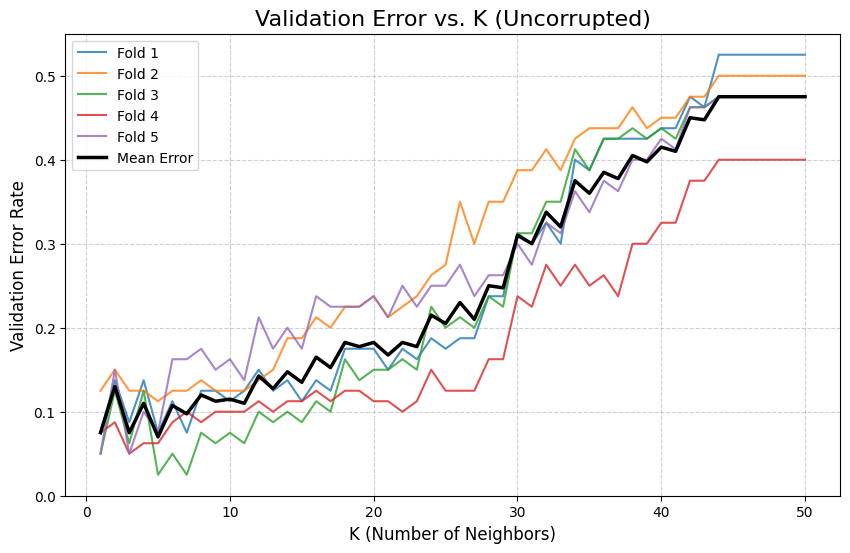

Findings for Uncorrupted:
  Best Mean Error: 0.0700
  Optimal K: 5

--- Running experiment for: Light-Corruption ---
Loaded data: MNIST-5-6-Subset-Light-Corruption.txt


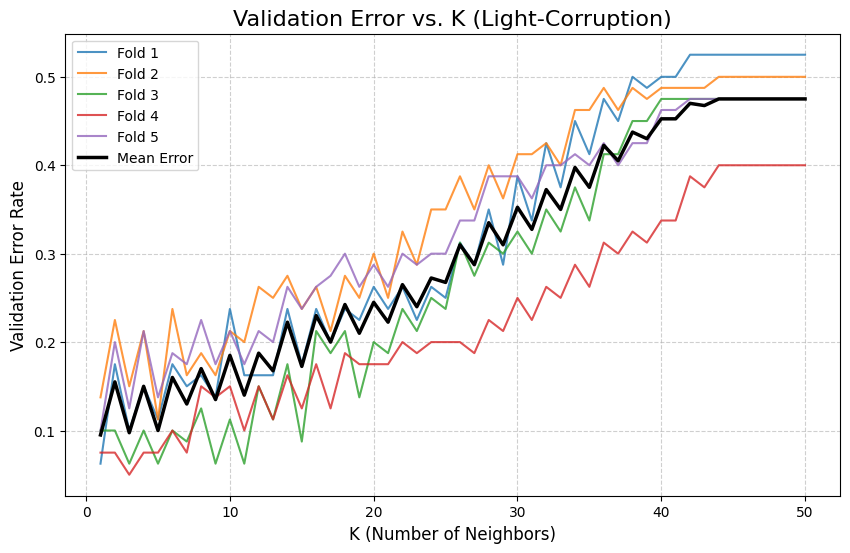

Findings for Light-Corruption:
  Best Mean Error: 0.0950
  Optimal K: 1

--- Running experiment for: Moderate-Corruption ---
ERROR: Could not load data file MNIST-5-6-Subset-Moderate-Corruption.txt. MNIST-5-6-Subset-Moderate-Corruption.txt not found.
--- Running experiment for: Heavy-Corruption ---
Loaded data: MNIST-5-6-Subset-Heavy-Corruption.txt


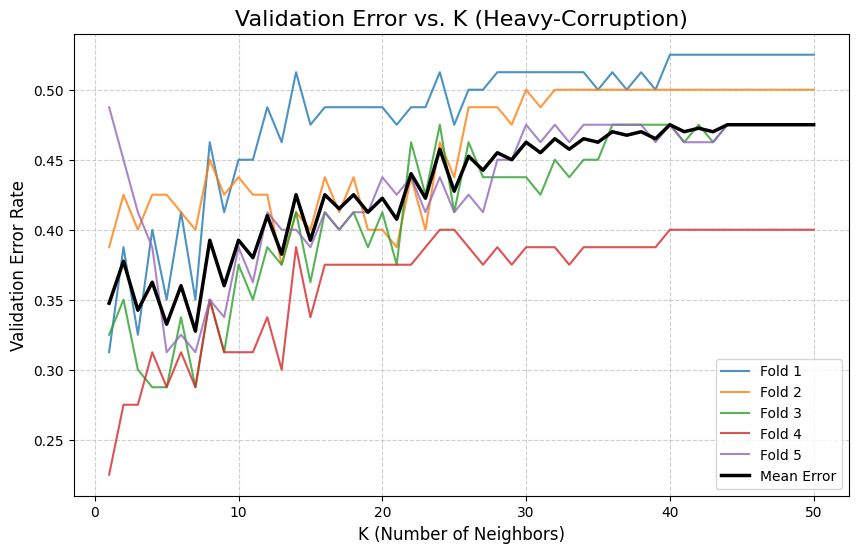

Findings for Heavy-Corruption:
  Best Mean Error: 0.3275
  Optimal K: 7

--- Final Analysis Summary ---
Uncorrupted: Min Error = 0.0700, Optimal K = 5
Light-Corruption: Min Error = 0.0950, Optimal K = 1
Heavy-Corruption: Min Error = 0.3275, Optimal K = 7


In [6]:
# --- For Task 2 ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Constants ---

DATA_DIR = Path("./")

DATA_FILE = DATA_DIR / "MNIST-5-6-Subset.txt"
LABELS_FILE = DATA_DIR / "MNIST-5-6-Subset-Labels.txt"
LIGHT_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Light-Corruption.txt"
MODERATE_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Moderate-Corruption.txt"
HEAVY_CORRUPT_FILE = DATA_DIR / "MNIST-5-6-Subset-Heavy-Corruption.txt"

M_TRAIN = 50  # Number of training points
N_VALIDATION = 80 # Validation set size for this experiment
K_VALUES = np.arange(1, M_TRAIN + 1)

# List of experiments to run
# (Name for plot, data file path)
EXPERIMENTS = [
    ("Uncorrupted", DATA_FILE),
    ("Light-Corruption", LIGHT_CORRUPT_FILE),
    ("Moderate-Corruption", MODERATE_CORRUPT_FILE),
    ("Heavy-Corruption", HEAVY_CORRUPT_FILE)
]

# -----------------------------------------------------------------
# PART 1: The Vectorized K-NN Function (Same as Task #1)
# -----------------------------------------------------------------

def knn(training_points, training_labels, test_points, test_labels):
    """
    Implements a fully vectorized K-NN classifier.
    """
    d, m = training_points.shape
    d, n = test_points.shape

    train_labels_norm = np.where(training_labels == 5, -1, 1)
    test_labels_norm = np.where(test_labels == 5, -1, 1)

    term1 = np.sum(np.square(training_points), axis=0).reshape(m, 1)
    term2 = -2 * (training_points.T @ test_points)
    term3 = np.sum(np.square(test_points), axis=0).reshape(1, n)
    dist_matrix_D = term1 + term2 + term3 + 1e-10

    sorted_indices = np.argsort(dist_matrix_D, axis=0)
    sorted_labels = train_labels_norm[sorted_indices]

    cumulative_votes = np.cumsum(sorted_labels, axis=0)
    predictions_all_K = np.sign(cumulative_votes)
    predictions_all_K[predictions_all_K == 0] = 1

    errors = (predictions_all_K != test_labels_norm)
    avg_errors_per_k = np.mean(errors, axis=1)

    return avg_errors_per_k

# -----------------------------------------------------------------
# PART 2: Run Task #2 Experiment
# -----------------------------------------------------------------

print("Starting K-NN Task #2 Experiment...")

# Load the labels (they are the same for all datasets)
try:
    labels = np.loadtxt(LABELS_FILE)
except Exception as e:
    print(f"ERROR: Could not load labels file. {e}")
    raise

# Store results for final discussion
analysis_results = {}

# --- Loop through each corruption level ---
for name, data_file_path in EXPERIMENTS:

    print(f"--- Running experiment for: {name} ---")

    # Load the specific dataset for this experiment
    try:
        data_matrix = np.loadtxt(data_file_path).reshape(1877, 784).T
        print(f"Loaded data: {data_file_path}")
    except Exception as e:
        print(f"ERROR: Could not load data file {data_file_path}. {e}")
        continue # Skip to the next experiment

    # Split data (same as Task #1)
    training_points = data_matrix[:, :M_TRAIN]
    training_labels = labels[:M_TRAIN]

    validation_data_pool = data_matrix[:, M_TRAIN:]
    validation_labels_pool = labels[M_TRAIN:]

    errors_for_folds = []

    # Run the 5-fold validation
    for i in range(5):
        start_idx = i * N_VALIDATION
        end_idx = (i + 1) * N_VALIDATION

        test_points = validation_data_pool[:, start_idx:end_idx]
        test_labels = validation_labels_pool[start_idx:end_idx]

        errors_k = knn(training_points, training_labels, test_points, test_labels)
        errors_for_folds.append(errors_k)

    # Convert list of 5 error vectors into a (5, 50) array
    errors_array = np.array(errors_for_folds)

    # --- Generate the plot for this corruption level ---
    plt.figure(figsize=(10, 6))

    for i in range(5):
        plt.plot(K_VALUES, errors_array[i, :], label=f'Fold {i+1}', alpha=0.8)

    # Plot the mean error as a thick, black line
    mean_error = np.mean(errors_array, axis=0)
    plt.plot(K_VALUES, mean_error, label='Mean Error', color='black', linewidth=2.5)

    plt.title(f'Validation Error vs. K ({name})', fontsize=16)
    plt.xlabel('K (Number of Neighbors)', fontsize=12)
    plt.ylabel('Validation Error Rate', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'validation_error_{name}.png')
    plt.show()

    # --- Store the findings for our final analysis ---
    min_error_rate = np.min(mean_error)
    optimal_k = K_VALUES[np.argmin(mean_error)]

    print(f"Findings for {name}:")
    print(f"  Best Mean Error: {min_error_rate:.4f}")
    print(f"  Optimal K: {optimal_k}\n")

    analysis_results[name] = (min_error_rate, optimal_k)

print("--- Final Analysis Summary ---")
for name, (err, k) in analysis_results.items():
    print(f"{name}: Min Error = {err:.4f}, Optimal K = {k}")